# Lesson 2: Baseline Email Assistant

This lesson builds an email assistant that:
- Classifies incoming messages (respond, ignore, notify)
- Drafts responses
- Schedules meetings

We'll start with a simple implementation - one that uses hard-coded rules to handle emails.

![Memory Course App](./img/memory_course_email.png)


## Load API tokens for our 3rd party APIs

In [ ]:
# pip install dotenv


  Using cached dotenv-0.9.9-py2.py3-none-any.whl.metadata (279 bytes)
Using cached dotenv-0.9.9-py2.py3-none-any.whl (1.9 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
from dotenv import load_dotenv
_ = load_dotenv()

## Setup a Profile, Prompt and Example Email

In [2]:
profile = {
    "name": "John",
    "full_name": "John Doe",
    "user_profile_background": "Senior software engineer leading a team of 5 developers",
}

In [3]:
prompt_instructions = {
    "triage_rules": {
        "ignore": "Marketing newsletters, spam emails, mass company announcements",
        "notify": "Team member out sick, build system notifications, project status updates",
        "respond": "Direct questions from team members, meeting requests, critical bug reports",
    },
    "agent_instructions": "Use these tools when appropriate to help manage John's tasks efficiently."
}

In [4]:
# Example incoming email
email = {
    "from": "Alice Smith <alice.smith@company.com>",
    "to": "John Doe <john.doe@company.com>",
    "subject": "Quick question about API documentation",
    "body": """
Hi John,

I was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?

Specifically, I'm looking at:
- /auth/refresh
- /auth/validate

Thanks!
Alice""",
}

## Define the first part of the agent - triage.

In [5]:
from pydantic import BaseModel, Field
from typing_extensions import TypedDict, Literal, Annotated
from langchain.chat_models import init_chat_model, AzureChatOpenAI



In [6]:
import os

os.environ["AZURE_OPENAI_API_KEY"] = "0bf3daeba1814d03b5d62e1da4077478"
os.environ["AZURE_OPENAI_ENDPOINT"] = "https://openaisk123.openai.azure.com/openai/deployments/gpt-35-turbo/chat/completions?api-version=2025-01-01-preview"
os.environ["AZURE_OPENAI_DEPLOYMENT_NAME"] = "gpt-35-turbo"
os.environ["AZURE_OPENAI_API_VERSION"] = "2024-05-01-preview"

In [7]:
# 2. Initialize the AzureChatOpenAI model
llm = AzureChatOpenAI(
    deployment_name=os.environ["AZURE_OPENAI_DEPLOYMENT_NAME"],
    openai_api_key=os.environ["AZURE_OPENAI_API_KEY"],
    openai_api_version=os.environ["AZURE_OPENAI_API_VERSION"],
    azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
    temperature=0.7,
    
)

/tmp/ipykernel_3585342/1600910419.py:2: LangChainDeprecationWarning: The class `AzureChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import AzureChatOpenAI``.
  llm = AzureChatOpenAI(


In [8]:
# llm = init_chat_model("openai:gpt-4o-mini")
response = llm.invoke("What is LangChain?")
print(response)


content='LangChain is a blockchain-based platform that aims to revolutionize the language learning industry. It uses smart contracts to connect language learners with tutors and language experts in a decentralized manner, allowing for more flexibility, transparency, and efficiency in the language learning process. Users can access a wide range of language learning resources, connect with tutors for personalized lessons, and track their progress using the platform. LangChain also offers a token system to incentivize users and reward them for their contributions to the platform.' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 97, 'prompt_tokens': 12, 'total_tokens': 109, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': 'fp_0165350fbb', 'finish_reason': 'stop', 'logprobs': None} id='run--6a5dd473-4729-4e81-bd58-5865b95bd500-0'


In [9]:
class Router(BaseModel):
    """Analyze the unread email and route it according to its content."""

    reasoning: str = Field(
        description="Step-by-step reasoning behind the classification."
    )
    classification: Literal["ignore", "respond", "notify"] = Field(
        description="The classification of an email: 'ignore' for irrelevant emails, "
        "'notify' for important information that doesn't need a response, "
        "'respond' for emails that need a reply",
    )

In [10]:
from langchain_core.tools import StructuredTool
from langchain_core.prompts import ChatPromptTemplate
from langchain.output_parsers.openai_tools import JsonOutputToolsParser
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import PromptTemplate
from pydantic import BaseModel, Field
from typing_extensions import TypedDict, Literal, Annotated

In [11]:
parser = PydanticOutputParser(pydantic_object=Router)
# Create a structured output prompt template
structured_output_prompt = """
{system_prompt}

{user_prompt}

{format_instructions}
"""

In [12]:
# Function to create a structured output from a system and user prompt
from langchain_core.messages import SystemMessage, HumanMessage
def get_structured_output(messages):
    """
    Process messages and return structured output.
    
    Args:
        messages: List of message dictionaries with 'role' and 'content'
    
    Returns:
        Router: A parsed Router object
    """
    # Convert dict messages to LangChain message objects
    lc_messages = []
    for msg in messages:
        if msg["role"] == "system":
            lc_messages.append(SystemMessage(content=msg["content"] + "\n\n" + parser.get_format_instructions()))
        elif msg["role"] == "user":
            lc_messages.append(HumanMessage(content=msg["content"]))
    
    # Invoke the model with the messages
    output = llm.invoke(lc_messages)
    
    # Parse the output into the Router object
    try:
        return parser.parse(output.content)
    except Exception as e:
        print(f"Error parsing output: {e}")
        print(f"Raw output: {output.content}")
        raise

In [13]:
from prompts import triage_system_prompt, triage_user_prompt

In [ ]:
# uncomment to view
#print(triage_system_prompt)
#print(triage_user_prompt)

In [14]:
system_prompt = triage_system_prompt.format(
    full_name=profile["full_name"],
    name=profile["name"],
    examples=None,
    user_profile_background=profile["user_profile_background"],
    triage_no=prompt_instructions["triage_rules"]["ignore"],
    triage_notify=prompt_instructions["triage_rules"]["notify"],
    triage_email=prompt_instructions["triage_rules"]["respond"],
)

In [15]:
user_prompt = triage_user_prompt.format(
    author=email["from"],
    to=email["to"],
    subject=email["subject"],
    email_thread=email["body"],
)

In [21]:
# result=get_structured_output(system_prompt,user_prompt)

In [16]:
result = get_structured_output(
    [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt},
    ]
)

In [17]:
print(result)

reasoning="This email contains a direct question from a team member regarding missing endpoints in the API documentation. It requires John's response to clarify if the missing endpoints were intentional or if the documentation needs to be updated." classification='respond'


## Main agent, define tools

In [18]:
from langchain_core.tools import tool

In [19]:
@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Write and send an email."""
    # Placeholder response - in real app would send email
    return f"Email sent to {to} with subject '{subject}'"

In [20]:
@tool
def schedule_meeting(
    attendees: list[str], 
    subject: str, 
    duration_minutes: int, 
    preferred_day: str
) -> str:
    """Schedule a calendar meeting."""
    # Placeholder response - in real app would check calendar and schedule
    return f"Meeting '{subject}' scheduled for {preferred_day} with {len(attendees)} attendees"



In [21]:
@tool
def check_calendar_availability(day: str) -> str:
    """Check calendar availability for a given day."""
    # Placeholder response - in real app would check actual calendar
    return f"Available times on {day}: 9:00 AM, 2:00 PM, 4:00 PM"

## Main agent, define prompt

In [22]:
from prompts import agent_system_prompt
def create_prompt(state):
    return [
        {
            "role": "system", 
            "content": agent_system_prompt.format(
                instructions=prompt_instructions["agent_instructions"],
                **profile
                )
        }
    ] + state['messages']

In [23]:
print(agent_system_prompt)


< Role >
You are {full_name}'s executive assistant. You are a top-notch executive assistant who cares about {name} performing as well as possible.
</ Role >

< Tools >
You have access to the following tools to help manage {name}'s communications and schedule:

1. write_email(to, subject, content) - Send emails to specified recipients
2. schedule_meeting(attendees, subject, duration_minutes, preferred_day) - Schedule calendar meetings
3. check_calendar_availability(day) - Check available time slots for a given day
</ Tools >

< Instructions >
{instructions}
</ Instructions >



In [24]:
from langgraph.prebuilt import create_react_agent

In [25]:
tools=[write_email, schedule_meeting, check_calendar_availability]

In [26]:
# Get the system message content once
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.agents import AgentExecutor, create_openai_functions_agent
system_content = agent_system_prompt.format(
    instructions=prompt_instructions["agent_instructions"],
    **profile
)

# Create a chat template with a fixed system message
prompt = ChatPromptTemplate.from_messages([
    ("system", system_content),  # Fixed content, not a lambda
    MessagesPlaceholder(variable_name="messages"),
    MessagesPlaceholder(variable_name="agent_scratchpad"),
])

# Create the agent with create_openai_functions_agent
agent = create_openai_functions_agent(llm, tools, prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)
  

In [27]:
response = agent_executor.invoke({
        "messages": [{"role": "user", "content": "what is my availability for tuesday?"}]
    })





> Entering new AgentExecutor chain...

Invoking: `check_calendar_availability` with `{'day': 'Tuesday'}`


Available times on Tuesday: 9:00 AM, 2:00 PM, 4:00 PMYou are available on Tuesday at 9:00 AM, 2:00 PM, and 4:00 PM. Let me know if you would like to schedule any meetings during these times.

> Finished chain.


In [28]:
print("response",response)

response {'messages': [{'role': 'user', 'content': 'what is my availability for tuesday?'}], 'output': 'You are available on Tuesday at 9:00 AM, 2:00 PM, and 4:00 PM. Let me know if you would like to schedule any meetings during these times.'}


## Create the Overall Agent

In [29]:
from langgraph.graph import add_messages

class State(TypedDict):
    email_input: dict
    messages: Annotated[list, add_messages]

In [30]:
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from typing import Literal
from IPython.display import Image, display

In [31]:
def triage_router(state: State) -> Command[
    Literal["response_agent", "__end__"]
]:
    author = state['email_input']['author']
    to = state['email_input']['to']
    subject = state['email_input']['subject']
    email_thread = state['email_input']['email_thread']

    system_prompt = triage_system_prompt.format(
        full_name=profile["full_name"],
        name=profile["name"],
        user_profile_background=profile["user_profile_background"],
        triage_no=prompt_instructions["triage_rules"]["ignore"],
        triage_notify=prompt_instructions["triage_rules"]["notify"],
        triage_email=prompt_instructions["triage_rules"]["respond"],
        examples=None
    )
    user_prompt = triage_user_prompt.format(
        author=author, 
        to=to, 
        subject=subject, 
        email_thread=email_thread
    )
    result = get_structured_output(
        [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ]
    )
    if result.classification == "respond":
        print("📧 Classification: RESPOND - This email requires a response")
        goto = "response_agent"
        update = {
            "messages": [
                {
                    "role": "user",
                    "content": f"Respond to the email {state['email_input']}",
                }
            ]
        }
    elif result.classification == "ignore":
        print("🚫 Classification: IGNORE - This email can be safely ignored")
        update = None
        goto = END
    elif result.classification == "notify":
        # If real life, this would do something else
        print("🔔 Classification: NOTIFY - This email contains important information")
        update = None
        goto = END
    else:
        raise ValueError(f"Invalid classification: {result.classification}")
    return Command(goto=goto, update=update)

## Put it all together

In [32]:
email_agent = StateGraph(State)
email_agent = email_agent.add_node(triage_router)
email_agent = email_agent.add_node("response_agent", agent)
email_agent = email_agent.add_edge(START, "triage_router")
email_agent = email_agent.compile()

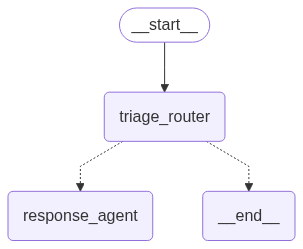

In [33]:
# Show the agent
display(Image(email_agent.get_graph(xray=True).draw_mermaid_png()))

In [34]:
email_input = {
    "author": "Marketing Team <marketing@amazingdeals.com>",
    "to": "John Doe <john.doe@company.com>",
    "subject": "🔥 EXCLUSIVE OFFER: Limited Time Discount on Developer Tools! 🔥",
    "email_thread": """Dear Valued Developer,

Don't miss out on this INCREDIBLE opportunity! 

🚀 For a LIMITED TIME ONLY, get 80% OFF on our Premium Developer Suite! 

✨ FEATURES:
- Revolutionary AI-powered code completion
- Cloud-based development environment
- 24/7 customer support
- And much more!

💰 Regular Price: $999/month
🎉 YOUR SPECIAL PRICE: Just $199/month!

🕒 Hurry! This offer expires in:
24 HOURS ONLY!

Click here to claim your discount: https://amazingdeals.com/special-offer

Best regards,
Marketing Team
---
To unsubscribe, click here
""",
}

In [35]:
response = email_agent.invoke({"email_input": email_input})

🚫 Classification: IGNORE - This email can be safely ignored


In [36]:
email_input = {
    "author": "Alice Smith <alice.smith@company.com>",
    "to": "John Doe <john.doe@company.com>",
    "subject": "Quick question about API documentation",
    "email_thread": """Hi John,

I was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?

Specifically, I'm looking at:
- /auth/refresh
- /auth/validate

Thanks!
Alice""",
}

In [38]:
response = email_agent.invoke({"email_input": email_input})

📧 Classification: RESPOND - This email requires a response


KeyError: 'intermediate_steps'

In [39]:
for m in response["messages"]:
    m.pretty_print()